### Import Library
- Tahap pertama adalah import seluruh library yang dibutuhkan


In [ ]:
import os                      # Mengakses sistem file dan path
import time                    # Mengukur waktu pelatihan
import random                  # Mengambil sampel acak untuk ditampilkan
import cv2                     # Membaca dan memproses gambar (OpenCV)
import numpy as np             # Perhitungan numerik array
import matplotlib.pyplot as plt  # Visualisasi data seperti gambar dan grafik
from glob import glob          # Mengambil path file dari folder tertentu
from collections import Counter  # Menghitung jumlah gambar per kelas

import tensorflow as tf        # Framework utama deep learning
from tensorflow.keras import Sequential             # Untuk membuat model Sequential
from tensorflow.keras.models import Model           # Untuk mendefinisikan model Keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout  # Layer-layer neural network
from tensorflow.keras.applications import ResNet50V2  # Model pre-trained ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau     # Callback training

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Digunakan untuk evaluasi performa model (akurasi, presisi, recall, dll.)

### Mount Google Drive
Untuk mengakses dataset yang disimpan di Google Drive.

In [ ]:
from google.colab import drive         # Modul khusus Google Colab
drive.mount('/content/drive')         # Mount folder Drive agar bisa diakses dari Colab

Mounted at /content/drive


### Menyalin Dataset ke Workspace
Menyalin dataset dari Google Drive ke direktori lokal Colab agar proses training lebih cepat.

In [ ]:
!cp -r /content/drive/MyDrive/TA/Dataset\ Final /content/dataset_final


### Memuat Dataset sebagai TensorFlow Dataset dan  Menghitung Jumlah Gambar per Kelas

- Menggunakan image_dataset_from_directory untuk memuat dataset terstruktur dalam folder (setiap subfolder dianggap sebagai label/kategori).

- Menggunakan Counter untuk mengetahui distribusi gambar dalam tiap kelas.


In [ ]:
data_dir = '/content/dataset_final'  # Path direktori dataset

data = tf.keras.utils.image_dataset_from_directory(
    data_dir,                        # Path folder dataset
    image_size=(224, 224),          # Ukuran gambar di-resize jadi 224x224 piksel
    batch_size=8,                   # Jumlah gambar per batch
    shuffle=True                    # Gambar diacak saat dimuat
)

class_names = data.class_names      # Menyimpan label kelas yang ditemukan
print("Class names:", class_names)  # Menampilkan nama kelas

label_counts = Counter()  # Inisialisasi penghitung jumlah label

for images, labels in data:
    for label in labels.numpy():
        class_name = class_names[label]  # Konversi label numerik ke nama kelas
        label_counts[class_name] += 1    # Tambah jumlah gambar per kelas

# Cetak jumlah gambar tiap kelas
print("\nJumlah gambar per kelas:")
total = 0
for class_name in class_names:
    count = label_counts[class_name]
    print(f"{class_name}: {count}")
    total += count
print(f"\nTotal semua gambar: {total}")


Found 17600 files belonging to 4 classes.
Class names: ['Kaca', 'Kardus', 'Logam', 'Plastik']

Jumlah gambar per kelas:
Kaca: 4400
Kardus: 4400
Logam: 4400
Plastik: 4400

Total semua gambar: 17600


### Menampilkan Sampel Gambar dari Setiap Kelas

Untuk memverifikasi isi dan kualitas dataset secara visual.

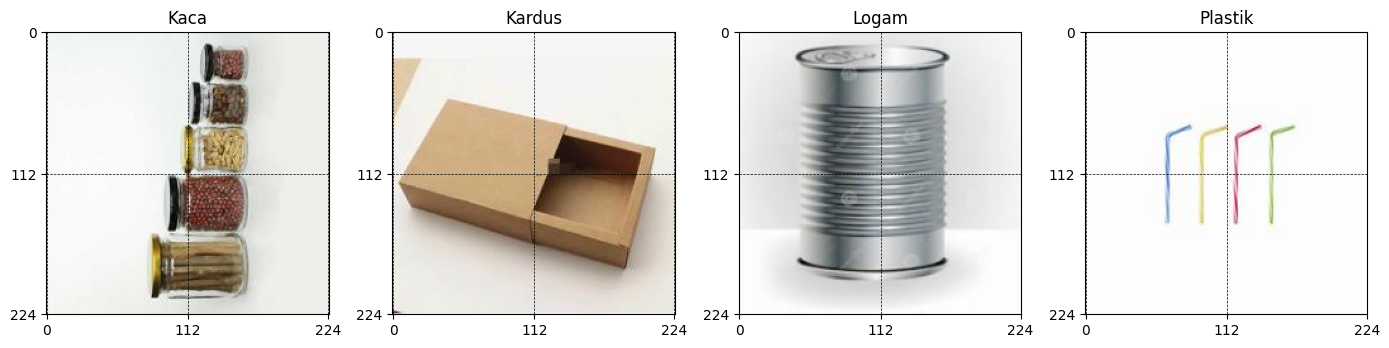

In [ ]:
plt.figure(figsize=(14, 6))  # Ukuran kanvas gambar 14x6 inci

for i, class_name in enumerate(class_names):  # Loop tiap kelas
    class_folder = os.path.join(data_dir, class_name)  # Path folder tiap kelas
    img_files = glob(os.path.join(class_folder, '*.jpg')) + \
                glob(os.path.join(class_folder, '*.jpeg')) + \
                glob(os.path.join(class_folder, '*.png'))  # Ambil semua file gambar

    if not img_files:
        continue

    img_path = random.choice(img_files)  # Pilih satu gambar secara acak
    img = cv2.imread(img_path)           # Baca gambar dengan OpenCV (format BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB

    plt.subplot(1, len(class_names), i + 1)  # Buat subplot
    plt.imshow(img)
    plt.title(class_name)  # Judul = nama kelas
    plt.xticks([0, img.shape[1]//2, img.shape[1]-1], labels=[0, img.shape[1]//2, img.shape[1]], color='black')
    plt.yticks([0, img.shape[0]//2, img.shape[0]-1], labels=[0, img.shape[0]//2, img.shape[0]], color='black')
    plt.grid(visible=True, color='black', linestyle='--', linewidth=0.5)  # Tampilkan grid
    plt.gca().spines['top'].set_color('black')   # Warna garis tepi
    plt.gca().spines['bottom'].set_color('black')
    plt.gca().spines['left'].set_color('black')
    plt.gca().spines['right'].set_color('black')

plt.tight_layout()
plt.show()

### Normalisasi Gambar (Rescaling 0-1)
Mengubah nilai piksel dari rentang 0-255 ke 0-1 agar model dapat memproses lebih stabil.

In [ ]:
for images, labels in data.take(1):  # Ambil satu batch
    print(f"Original pixel range: min={tf.reduce_min(images).numpy()}, max={tf.reduce_max(images).numpy()}")
    original_images = images.numpy().astype("uint8")  # Konversi ke uint8

# Fungsi normalisasi
def process_images(images, labels):  # Fungsi normalisasi
    images = tf.cast(images, tf.float32) / 255.0  # Bagi nilai piksel dengan 255
    return images, labels

data = data.map(process_images)  # Terapkan normalisasi ke semua batch

for images, labels in data.take(1):
    print(f"Normalized pixel range: min={tf.reduce_min(images).numpy()}, max={tf.reduce_max(images).numpy()}")

# Tampilkan ukuran gambar
print(f"Image shape: {images[0].shape}")

Original pixel range: min=0.0, max=255.0
Normalized pixel range: min=0.0, max=1.0
Image shape: (224, 224, 3)


### Membagi Dataset (Train, Validation, Test)
Dataset dibagi menjadi 80% training, 10% validation, dan 10% test.

- Train, digunakan untuk melatih model agar mengenali pola dalam data
- Validation, digunakan untuk mengevaluasi performa model selama pelatihan
- Test, digunakan untuk menguji model setelah pelatihan

In [ ]:
total_batches = tf.data.experimental.cardinality(data).numpy()  # Total batch
train_size = int(0.8 * total_batches)  # 80% untuk pelatihan
val_size = int(0.1 * total_batches)    # 10% untuk validasi

train_data = data.take(train_size)
val_test_data = data.skip(train_size)
val_data = val_test_data.take(val_size)
test_data = val_test_data.skip(val_size)

### Optimisasi Pipeline Dataset
Menggunakan shuffle() dan prefetch() untuk efisiensi pelatihan.

In [ ]:
train_data = train_data.shuffle(100).prefetch(1)  # Acak & prefetch batch untuk training
val_data = val_data.prefetch(1)                   # Prefetch batch validasi
test_data = test_data.prefetch(1)                 # Prefetch batch uji

### Load Model Pre-trained ResNet50V2
Mengimpor model ResNet50V2 tanpa bagian top (klasifikasi), digunakan sebagai feature extractor.

In [ ]:
base_model = ResNet50V2(
    include_top=False,           # Tidak termasuk layer klasifikasi
    weights='imagenet',          # Bobot pre-trained dari ImageNet
    input_shape=(224, 224, 3)    # Ukuran input sesuai gambar
)
base_model.trainable = False     # Bekukan layer agar tidak dilatih ulang

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


###  Membangun Arsitektur Model
Menambahkan layer custom seperti GlobalAveragePooling, Dense, dan Dropout.

In [ ]:
model = Sequential([             # Gunakan model sequential
    base_model,                          # Feature extractor (ResNet50V2)
    GlobalAveragePooling2D(),            # Pooling semua fitur ke satu vektor
    Dropout(0.3),                        # Dropout untuk mencegah overfitting
    Dense(64, activation='relu'),       # Hidden layer dengan 64 neuron
    Dropout(0.3),                        # Dropout kembali
    Dense(len(class_names), activation='softmax')  # Output layer: klasifikasi 4 kelas
])

model.compile(
    optimizer='adam',                     # Optimizer Adam
    loss='sparse_categorical_crossentropy',  # Loss untuk label integer (bukan one-hot)
    metrics=['accuracy']                 # Ukur performa dengan akurasi
)
model.summary()  # Tampilkan struktur model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,696,196 (90.39 MB)

 Trainable params: 131,396 (513.27 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Menambahkan Callbacks
- EarlyStopping: Menghentikan pelatihan jika validasi tidak membaik.

- ReduceLROnPlateau: Mengurangi learning rate jika model stagnan.

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)  # Stop jika val loss tak membaik 5 epoch
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)   # Kurangi LR jika stagnan 3 epoch

### Melatih Model
Melatih model dan mengukur waktu pelatihan.

In [ ]:
start_time = time.time()  # Mulai hitung waktu
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)
end_time = time.time() # Catat waktu selesai
elapsed_time = end_time - start_time # Hitung total waktu pelatihan

print(f"Training time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")

Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 67s 30ms/step - accuracy: 0.7704 - loss: 0.6205 - val_accuracy: 0.9080 - val_loss: 0.2688 - learning_rate: 0.0010
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.8901 - loss: 0.3095 - val_accuracy: 0.9284 - val_loss: 0.2216 - learning_rate: 0.0010
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.9095 - loss: 0.2452 - val_accuracy: 0.9369 - val_loss: 0.1886 - learning_rate: 0.0010
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9233 - loss: 0.2098 - val_accuracy: 0.9364 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 5/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.9271 - loss: 0.1987 - val_accuracy: 0.9403 - val_loss: 0.1784 - learning_rate: 0.0010
Epoch 6/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accuracy: 0.9326 - loss: 0.1832 - val_accuracy: 0.9438 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 7/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accura

###  Visualisasi Akurasi dan Loss
Grafik ini menunjukkan perkembangan kinerja model selama pelatihan.

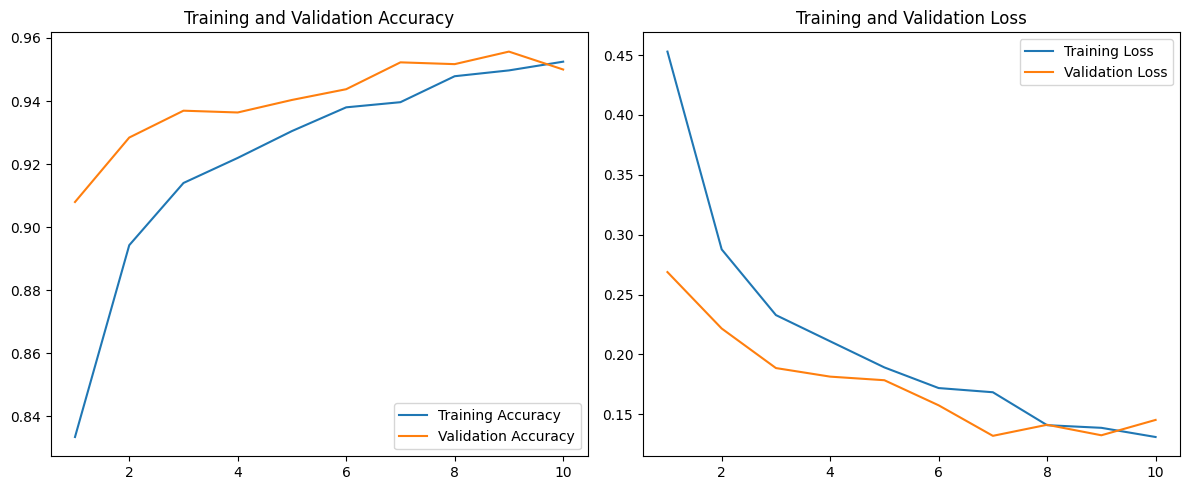

In [ ]:
epochs_range = range(1, len(history.history['accuracy']) + 1) # Range sesuai jumlah epoch

plt.figure(figsize=(12, 5))  # Ukuran kanvas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

### Evaluasi Model dengan Confusion Matrix dan Classification Report
Mengetahui presisi, recall, dan f1-score dari model pada data uji.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━

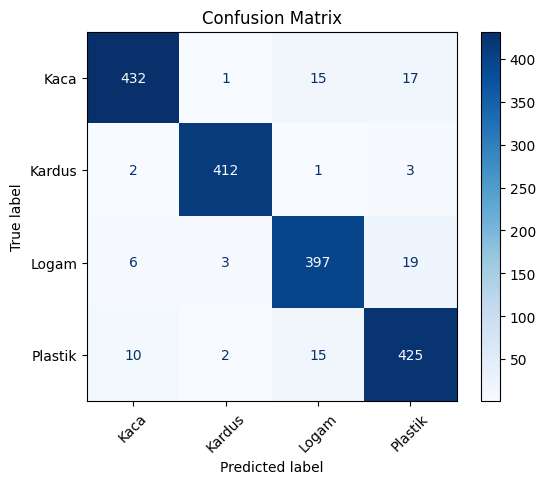

In [ ]:
y_true = [] # Label asli
y_pred = [] # Hasil prediksi

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy()) # Simpan label asli
    y_pred.extend(np.argmax(preds, axis=1)) # Ambil prediksi label dengan nilai tertinggi

print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred) # Matriks kebingungan
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


### Prediksi dan Visualisasi pada Sampel Data Uji
Menampilkan 8 sampel gambar dari data uji beserta label asli dan hasil prediksi.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


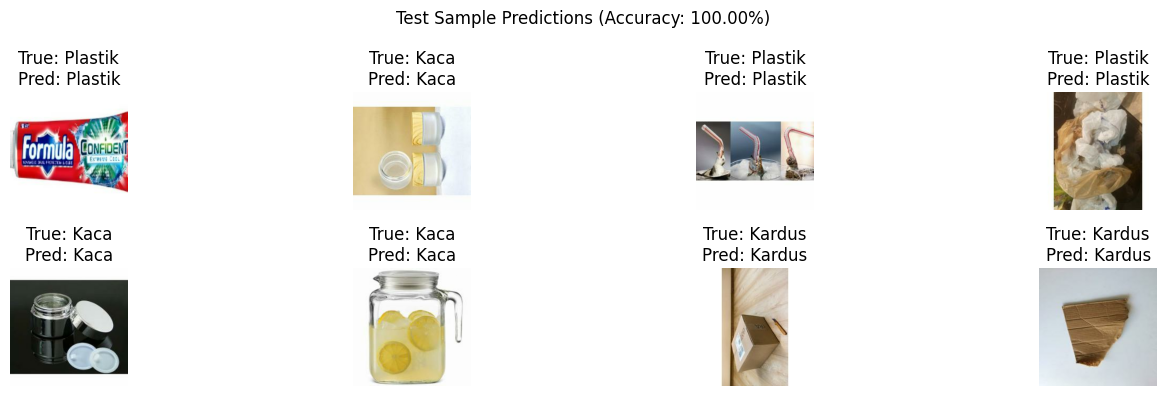

In [ ]:
def test_and_visualize(model, test_data, class_names):
    for images, labels in test_data.take(1):  # Ambil 1 batch dari test set
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)  # Ambil prediksi label
        acc = np.mean(pred_labels == labels.numpy()) * 100  # Hitung akurasi

        plt.figure(figsize=(15, 4))
        for i in range(min(8, len(images))):  # Maksimum 8 gambar ditampilkan
            plt.subplot(2, 4, i+1)
            plt.imshow(images[i].numpy())
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
            plt.axis("off")
        plt.suptitle(f"Test Sample Predictions (Accuracy: {acc:.2f}%)")
        plt.tight_layout()
        plt.show()
        break

# Panggil fungsi
test_and_visualize(model, test_data, class_names)